
## **Generating Segments of Gravtiational Wave Detector Noise**

Continuing from the normalising flows tutorial ([HERE](https://colab.research.google.com/github/phas-ml/phas-ml.github.io/blob/master/notebooks/2021_02_10_normalising_flows_tutorial.ipynb#scrollTo=33I8OfDiNdAh)) the code is adapted for many more dimensions - the principle is exactly the same but slightly harder to visualise. Instead of there being sets of 2 datapoints in a plane we now have many more, even hundreds, of dimensions. The loss function is exactly the same:


## Loss function

As with any machine learning algorithm we need to define a loss function. This is actually relatively easy for a normalising flow.

A normalising flow applies a mapping $f: x \to z$ conditioned on its parameters $\theta$ which are typically the trainable parameters of a neural network. In this context the goal of training a normalising flow is to approximate a target distribution $p^{*}_{x}(x)$. The KL divergence between the target distribution and the distribution of the flow $p_{x}(x|\theta)$ can be written as:

$$
\begin{split}
    \mathcal{L}(\theta)  = & D_{\textrm{KL}}[p^{*}_{x}(x) ||p_{x}(x|\theta) ] \\
    = & - \mathbb{E}_{p^{*}_{x}(x)} [\ln p_{x}(x|\vec{\theta})] + \textrm{const.} \\
    = & - \mathbb{E}_{p^{*}_{x}(x)} \left[\ln p_{z}(f(x|\theta)) + \ln \left|\textrm{det} \frac{\partial f(x|\theta)}{\partial x^{T}} \right|\right] + \textrm{const.}.
\end{split}
$$

Then, assuming the set of K samples used for training is drawn from $p^{*}_{x}(x)$, the expectation value can be approximated as:

$$
    \mathcal{L}(\theta) \approx - \frac{1}{K} \sum_{k=1}^{K} \ln p_{z}(f(x|\vec{\theta})) + \ln \left|\textrm{det} \frac{\partial f(x|\vec{\theta})}{\partial x^{T}} \right|.
$$

This loss function is often known as the **negative log-likelihood** or NLL. In practice this is just the mean of the log-probabilties computed with the flow.


## Import data

We will use gwpy to download some GW detector data ([gwpy documentation](https://gwpy.github.io/docs/stable/timeseries/remote-access.html)). 

In [ ]:
#Install gwpy and packages
! pip install -q 'gwpy==1.0.1'

from gwpy.timeseries import TimeSeries
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#Select the number of datapoints we will train on and hence be able to generate
n_datapoints = 256

#Select the length of downloaded sample in seconds
n_seconds = 24000

#Segment of GPS times
segment = (1243437410,1243437410+n_seconds) 

#Fetch data from L1
ldata = TimeSeries.fetch_open_data('L1', *segment, verbose=True, cache=True) #cache stores so doesnt need to be downloaded again
data = np.array(ldata.data) #turn into numpy ndarray

Fetched 7 URLs from www.gw-openscience.org for [1243437410 .. 1243461410))
Reading data... 

/usr/local/lib/python3.7/dist-packages/gwpy/types/series.py:926: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  % type(self).__name__)


[Done]
Reading data... 

/usr/local/lib/python3.7/dist-packages/gwpy/types/series.py:917: UserWarning: TimeSeries.crop given start smaller than current start, crop will begin when the Series actually starts.
  % type(self).__name__)


[Done]
Reading data... [Done]
Reading data... [Done]
Reading data... [Done]
Reading data... [Done]
Reading data... [Done]


It's important to view our training data - in this case there may be some certain noise characteristics that don't appear at all in the first 1000 seconds but are the dominant noise frequency later on. Ideally we would want the network to see enough data and instances of all the kinds of noise the specific detector encounters - so that when we use it to generate new samples there is a chance we get an unusual piece of noise that is rare but possible. 

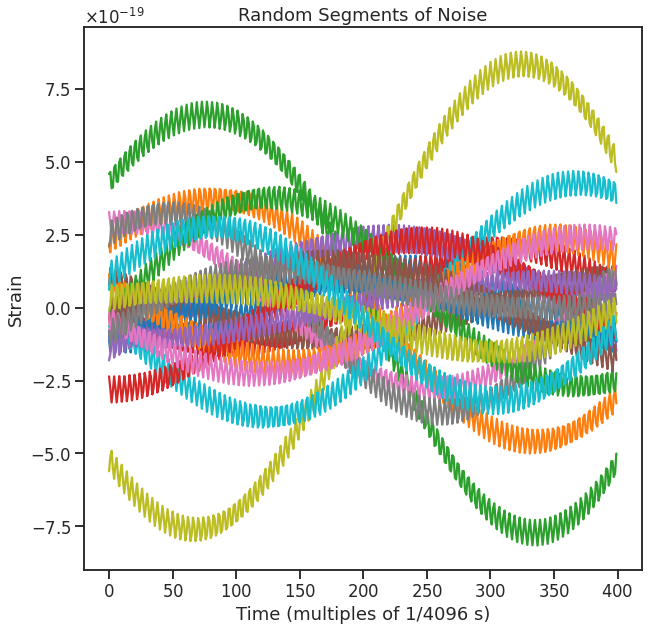

In [ ]:
#Choose random segments to sample data 
n_segments = np.random.choice(len(ldata), size = (20,))

fig = plt.figure(figsize=(10,10))

#plot the 200s of data around the randomly selected point
for i in n_segments:
  plt.plot(data[i-200:i+200])

plt.title('Random Segments of Noise')
plt.ylabel('Strain')
plt.xlabel('Time (multiples of 1/4096 s)')
plt.show()

##Setting up data

Neural networks are much better when the data is scaled between 0 and 1. The following cell does just this. Next we need to split our huge data array into the segments of datapoints we want to train on. This takes a little thought if you are changing the number of datatpoints (n_datapoints). Since the sampling rate of the data is 4096Hz it'll always split evenly if using 8,16,32,64,128,256,512... as your n_datapoints - so stick to this. 

In [ ]:
#Scale the data
  #Find the max value
maximum_value = max(abs(data))
  #Divide all values by max
data = data/maximum_value

#Calculates split in size
n_split = np.shape(data)[0]/n_datapoints

#Split to get n datapoints per set
data_split = np.split(data,n_split)

samples = np.array(data_split)
print('The final samples array size is', np.shape(samples))

The final samples array size is (384000, 256)


The data is now split into an array we can use to split into training and validation data and make sure it's in the right format (tensors). 

##The Model

First, some housekeeping - the packages that the model will need to use:

In [ ]:
import copy
import seaborn as sns
import torch

sns.set_context('talk')
sns.set_style('ticks')

!pip install nflows

#for coupling transforms
import torch.nn.functional as F

from nflows.distributions import StandardNormal
from nflows import transforms
from nflows.nn.nets import ResidualNet

from torchvision import datasets, transforms as T

Next is the real-valued non-volume preserving (RealNVP). This is the basic normalising flow and we can observe the calculated log probabilities. nflows includes the coupling transforms already, so we need to construct a model that contain various coupling transforms. Each of these transforms will have a neural network that parameterises the scale and translation parameters. We're going to use a residual neural network, since this is also included in nflows.

The following cell sets up our model. Don't worry about the paramters here as we input our own when we call the class later. You might want to consider changing the activation function, dropout probability and batch normalisation here however.

In [ ]:
class ImprovedRealNVP(torch.nn.Module):
    def __init__(self, 
                n_dims=None, 
                n_transforms=1,
                n_layers_per_transform=2,
                n_neurons_per_layer=2):
        super().__init__()

        # Define function for creating the neural network
        def create_net(in_features, out_features):
                return ResidualNet(
                    in_features,
                    out_features,
                    hidden_features=n_neurons_per_layer,
                    context_features=None,
                    num_blocks=n_layers_per_transform,
                    activation=F.elu,
                    dropout_probability=0.1,
                    use_batch_norm=True
                    )
        
        def create_linear_transform():
            return transforms.CompositeTransform([
                transforms.RandomPermutation(features=n_dims),
                transforms.LULinear(n_dims, identity_init=True,
                                    using_cache=False)
            ])

        # Make an alternating mask. If the value is one, the parameter is updated
        # if it <0 then it is used as the input to the NN
        mask = torch.ones(n_dims)
        mask[::2] = -1

        transforms_list = []
        for i in range(n_transforms):
            transforms_list.append(create_linear_transform())
            transform = transforms.AffineCouplingTransform(
                mask=mask, transform_net_create_fn=create_net
            )
            transforms_list.append(transforms.BatchNorm(features=n_dims))
            mask *= -1
            transforms_list.append(transform)

        self.transform = transforms.CompositeTransform(transforms_list)
        self.distribution = StandardNormal([n_dims])

    def forward(self, x):
        """
        Apply the forward transformation and return samples in the latent
        space and log |J|
        """
        return self.transform.forward(x)

    def inverse(self, z):
        """
        Apply the inverse transformation and return samples in the
        data space and log |J| (not log probability)
        """
        return self.transform.inverse(z)

    def log_prob(self, x):
        """
        Computes the log probability of the inputs samples by applying the
        transform.
        """
        z, logabsdet = self.transform(x)
        log_prob = self.distribution.log_prob(z)
        return log_prob + logabsdet

    def sample(self, n):
        """
        Produces N samples in the data space by drawing from the base
        distribution and the applying the inverse transform.
        """
        z = self.distribution.sample(n)
        samples, _ = self.transform.inverse(z)
        return samples

The next cell verifies the NF implementation - that it is invertible and has a tractable Jacobian. These are the parameters you can change: number of transforms, layers per transform and neurons per layer. 

In [ ]:
flow = ImprovedRealNVP(n_datapoints, 1, 2, 2)
flow.to('cuda') #use GPU

ImprovedRealNVP(
  (transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): CompositeTransform(
        (_transforms): ModuleList(
          (0): RandomPermutation()
          (1): LULinear()
        )
      )
      (1): BatchNorm()
      (2): AffineCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=128, out_features=2, bias=True)
          (blocks): ModuleList(
            (0): ResidualBlock(
              (batch_norm_layers): ModuleList(
                (0): BatchNorm1d(2, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
                (1): BatchNorm1d(2, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              )
              (linear_layers): ModuleList(
                (0): Linear(in_features=2, out_features=2, bias=True)
                (1): Linear(in_features=2, out_features=2, bias=True)
              )
              (dropout): Dropout(p=0.1, inplace=False)
            )
  

##Setup the model:

Now the optimiser is setup, you can alter the learning rate and the weight decay here as well as the training settings. The data is also split and shuffled into training and validation data as well as loaded into the right format.

In [ ]:
#Create optimiser
optimiser = torch.optim.Adam(flow.parameters(), lr=1e-4, weight_decay=1e-6)

#Configure training
n_epochs = 400
patience = 1000
batch_size = 2048

#Split data into training and validation
from sklearn.model_selection import train_test_split


x_train, x_val = train_test_split(samples, test_size=0.25)
train_tensor = torch.from_numpy(x_train.astype(np.float32))
train_dataset = torch.utils.data.TensorDataset(train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True)

val_tensor = torch.from_numpy(x_val.astype(np.float32))

Here goes the actual training:

In [ ]:
%%time
# Variables for checkpointing
best_epoch = 0
best_val_loss = np.inf
best_model = copy.deepcopy(flow.state_dict())

# Loss
loss_dict = dict(train=[], val=[])

for n in range(n_epochs):
    
    # Train
    train_loss = 0
    flow.train()
    for x_tensor in train_loader:
        optimiser.zero_grad()
        loss = -flow.log_prob(x_tensor[0].to('cuda')).mean()
        loss.backward()
        optimiser.step()
        train_loss += loss.cpu().detach().numpy()
    train_loss /= len(train_loader)
    loss_dict['train'].append(train_loss)
    
    # Validate
    with torch.no_grad():
        flow.eval()
        val_loss = - flow.log_prob(val_tensor.to('cuda')).mean().cpu().numpy()
        
    loss_dict['val'].append(val_loss)

    # Save the best model for use at the end
    if val_loss < best_val_loss:
        best_epoch = n
        best_val_loss = val_loss
        best_model = copy.deepcopy(flow.state_dict())
        
    # Print loss every n epochs
    if not n % 5:
        print(f'{n}: Train loss: {train_loss:1.4f}')
        print(f'{n}: Val loss: {val_loss:1.4f}')
        #print('Example generation:')
        #with torch.no_grad():
          #  x_out = flow.sample(1).cpu().numpy()
       # plt.plot(x_out.T)
        #plt.xlabel(r'$x_0$')
       # plt.ylabel(r'$x_1$')
        #plt.title('New samples')
       # plt.show()

    # Early stopping
    if n - best_epoch > patience:
        print('Reached patience')
        break

# Load the best model
print('Finished training')
print(f'Best epoch: {best_epoch}')
print('Loading best model')
flow.load_state_dict(best_model)
flow.eval()

0: Train loss: -462.9978
0: Val loss: -695.1236
5: Train loss: -1203.2546
5: Val loss: -1207.4283
10: Train loss: -1231.2065
10: Val loss: -1233.3214
15: Train loss: -1253.9929
15: Val loss: -1255.7299
20: Train loss: -1275.5773
20: Val loss: -1277.2965
25: Train loss: -1297.3506
25: Val loss: -1298.3900
30: Train loss: -1317.5017
30: Val loss: -1318.7936
35: Train loss: -1335.1180
35: Val loss: -1335.6989
40: Train loss: -1350.3312
40: Val loss: -1350.7985
45: Train loss: -1363.1723
45: Val loss: -1363.5214
50: Train loss: -1375.3116
50: Val loss: -1373.4578
55: Train loss: -1387.3595
55: Val loss: -1387.0476
60: Train loss: -1399.3184
60: Val loss: -1399.3966
65: Train loss: -1410.7008
65: Val loss: -1410.3074
70: Train loss: -1421.5844
70: Val loss: -1421.4147
75: Train loss: -1431.5211
75: Val loss: -1430.8074
80: Train loss: -1441.1388
80: Val loss: -1439.7283
85: Train loss: -1450.7086
85: Val loss: -1449.1893
90: Train loss: -1459.9659
90: Val loss: -1458.6233
95: Train loss: -1

## Results

And here is the loss plot we have generated, study this to inform how you need to alter the network.

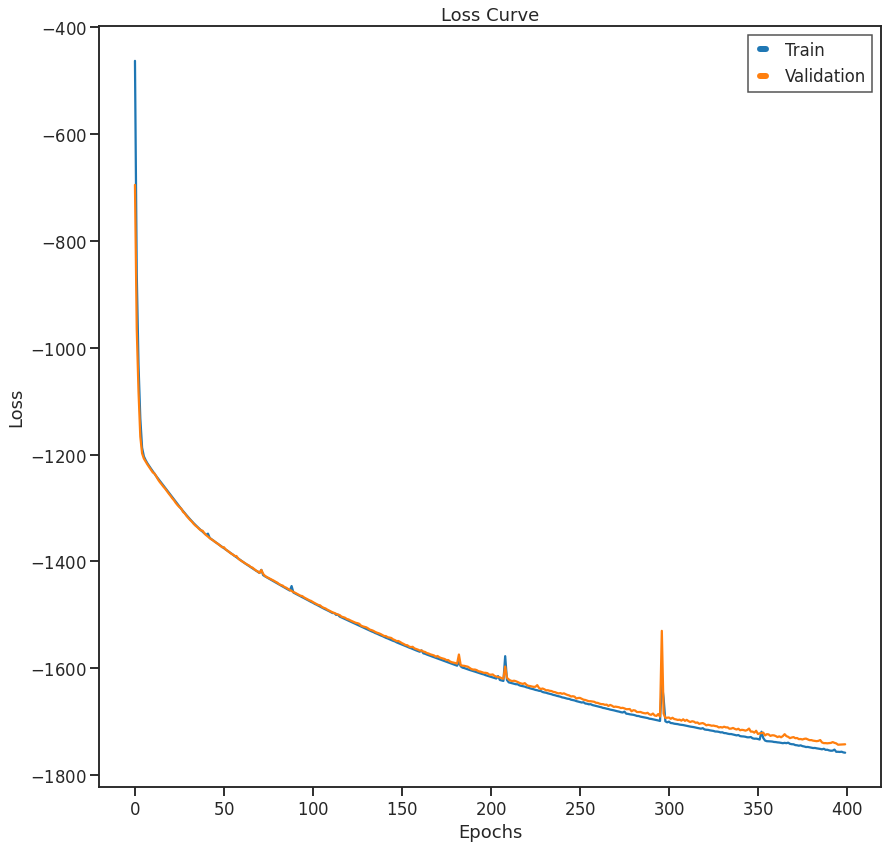

In [ ]:
fig = plt.figure(figsize=(14,14))
plt.plot(loss_dict['train'], label='Train')
plt.plot(loss_dict['val'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()


##Plotting transforms

256


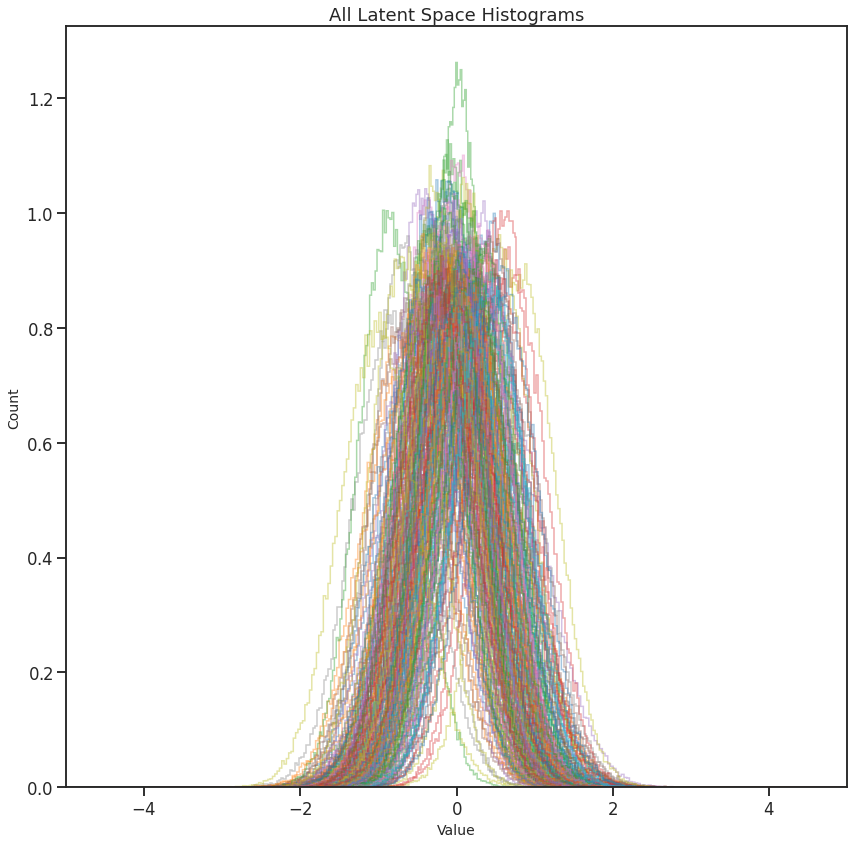

In [ ]:
#flow forward using validation data
with torch.no_grad():
    z, _ = flow.forward(val_tensor.to('cuda'))
    z = z.cpu().numpy()


fig = plt.figure(figsize=(14,14))
print(np.shape(z)[1])
for i in range(0,np.shape(z)[1]):
  plt.hist(x=z[:,i], bins='auto', alpha=0.4, density=True, histtype='step')
  
plt.xlabel("Value", size=14)
plt.ylabel("Count", size=14)
plt.title("All Latent Space Histograms")
plt.xlim(-5,5)
plt.show()

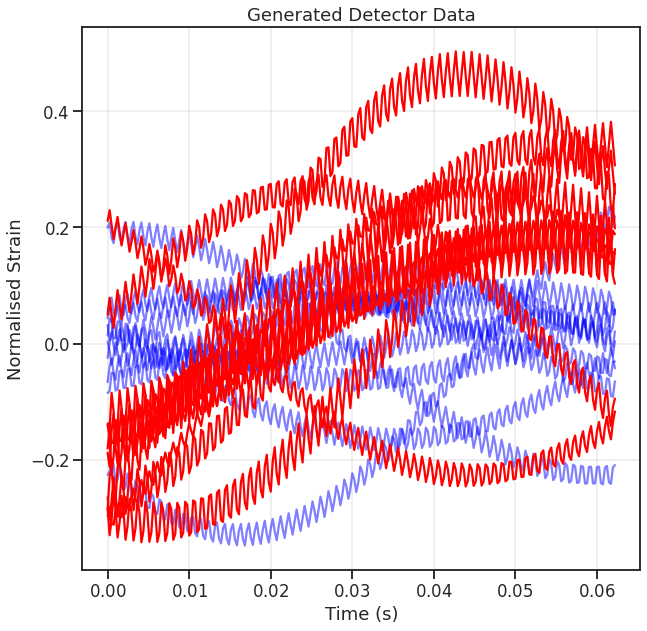

In [ ]:
n = 10
with torch.no_grad():
    x_out = flow.sample(n).cpu().numpy()

fig = plt.figure(figsize=(10,10))
plt.title('New And Original Samples')

#Plot original data
idx = np.random.randint(0,samples.shape[0],n)

times = np.arange(0,n_datapoints,1)*(1/4096)

for i in idx:
    plt.plot(times,samples[i,:],alpha=0.5, color = 'blue', label='original')

#fig = plt.figure(figsize=(10,10))

#Plot new samples
plt.plot(times, x_out.T, color = 'red', label='generated')
plt.grid(which='both', alpha=0.4)
plt.xlabel('Time (s)')
plt.ylabel('Normalised Strain')
plt.title('Generated Detector Data')
plt.show()

In [ ]:
#Analyse the frequency space
print(idx)

r = int((n_datapoints/2)+1)  #size of output from fft

#Create arrays
fft_samples = np.empty((n_datapoints,r))
fft_generated = np.empty((n_datapoints,r))

#Get fft
for i in range(0,n_datapoints):
  fft_samples[i,:]=np.fft.rfft(samples[i,:])
  fft_generated[i,:]=np.fft.rfft(x_out[i,:])

fft_generated = np.square(np.abs(fft_generated))
fft_samples = np.square(np.abs(fft_samples))

[272724 110019 317374 207779 275660  32036 382207 293958 176344
 172214]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


IndexError: ignored

In [ ]:
fig = plt.figure(figsize=(14,14))

T = n_datapoints/4096.0
d_f = 1.0/T
f_vec = np.arange(r)*d_f

#BLUE = SAMPLE DATA ; RED = GENERATED 

for i in range(0,n_datapoints):
    plt.plot(f_vec, fft_samples[i,:],alpha=0.5, color = 'blue', label='Original Data', linewidth = 0.3)
    plt.plot(f_vec, fft_generated[i,:],alpha=0.5, color = 'red', label='Generated Data', linewidth = 0.3)

plt.yscale("log")
plt.xscale("log")
plt.xlabel('Frequency ($s^{-1}$)')
plt.title('FFT of Generated and Original Detector Data')
plt.grid(which='both', alpha=0.4)
plt.ylabel('Amplitude')


In [ ]:
#Take average values of generated and sample curves in frequency domain

fft_samples_mean = np.mean(fft_samples, axis=0)

fft_generated_mean = np.mean(fft_generated, axis=0)

#Plot

fig = plt.figure(figsize=(14,14))

plt.plot(fft_samples_mean, color = 'blue', label = 'Sample data')
plt.plot(fft_generated_mean, color = 'red', label = 'Generated data')
plt.yscale('log')
plt.xscale('log')
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Frequency ($s^{-1}$)')
plt.title('FFT of Generated and Original Detector Data')
plt.grid(which='both', alpha=0.4)
plt.ylabel('Amplitude')

plt.legend()
plt.show()